<h1>
    <center>
        TMA4320 Prosjekt 2

# Innholdsfortegnelse

## 1. Introduksjon
## 2. Generell algoritme
## 3. Første testproblem: Punkter i planet
## 4. Andre testproblem: MNIST - siffergjenkjenning
## 5. Avslutning


# 1. Introduksjon

Formålet med prosjektet er å gi en introduksjon til maskinlæring, nærmere bestemt dyplæring og dype nevrale nettverk, ved egen implementering av algoritmene. 
Ideen er å trene dataprogrammet til å gjenkjenne bildeelementer i to ulike testproblemer. I det første testproblemet er problemstillingen forenklet til gjenkjenning av fargede datapunkt, mens i det andre testproblemet skal programmet kunne skille mellom to ulike håndskrevne sifre. 
Denne rapporten skal først presentere den grunneleggende algoritmen som benyttes i treningsfasen og hovedsaklig er lik for begge problemstillingene, før hver problemstilling blir framstilt i detalj.
Valg av startparametre skal begrunnes og parametrene som ble funnet i treningsfasen skal presenteres. Deretter skal modellen med disse fikserte parametrene kjøres med nye data og resultatene bli lagt fram og diskutert.

# 2. Generell algoritme

Algoritmen for det nevrale nettverket er delt inn i ulike funksjoner for å forenkle kodestrukturen. Først blir det laget fire tilfeldige parametere; $K$ vektere $W_{k}$, $K$ bias $b_{k}$, en vektor $\omega$ og en skalar $\mu$. $K$ er totalt antall lag i transformasjonen. Videre blir et bilde $Y_k$ transformert til det neste laget $k+1$ ved hjelp av en vekter, en bias og funksjonen $\sigma (x)$. Når de  $I$ bildene har blitt transformert gjennom alle lagene blir hver av de projisert ned på en skalar $Z$ ved hjelp av $\omega$, $\mu$ og funksjonen $\eta (x)$. Verdiene for hvert av de $I$ bildene i $Z$ blir sammenliknet med fasitverdiene i $c$, og denne differansen representeres i $J$. For å minimere $J$ blir de fire gradientene til $J$ med hensyn på de ulike parameterne funnet. Deretter blir vekter, bias $\omega$ og $\mu$ optimert ved hjelp av enten "plain vanilla gradient descent" eller Adam-metoden. Parameterne blir også lagret i en tekstfil for hver transformasjon gjennom de $K$ lagene. 

In [78]:
import numpy as np
from matplotlib import pyplot as plt
import math
import random 
import timeit

importerte filer

In [79]:
from loader import load_mnist
from loader import get_dataset
from spirals import get_data_spiral_2d

In [ ]:
#Ha en egen boks for parameterne? 

Treningen av algoritmen, både for punkter i planet og siffergjenkjenning, foregår i funksjonen $trening$. Den er laget slik at det er valgfritt hvilken optimeringsmetode av parameterne man vil bruke. Adam-metoden bruker en tilfeldig trukket bunke med bilder fra de importerte bildefilene som den legger til i matrisen $Y_k$.

In [80]:

def trening(images, labels, AdamOrPlain = 'plain', n=1000, h = 0.05, K = 20):
    d = 2
    W_k, b_k, omega, my = getRandomParam(d, K)
    W_k = np.dot(W_k, 1/(d**2))
    omega = np.dot(omega, 1/(d**2))

    if AdamOrPlain == 'adam':
        mW, mb, mOmega, mMy = getStartMandV(W_k,b_k,omega,my)
        vW, vb, vOmega, vMy = getStartMandV(W_k, b_k, omega, my)

    elif AdamOrPlain == 'plain':
        tau = 0.1
    else:
        print("Må være enten adam eller plain")

    J_list = []

    for i in range(n):
        Y_k = [images]
        for i in range(W_k.shape[0]):
            Y_next = findNextYMat(Y_k[-1], W_k[i], b_k[i], h)
            Y_k.append(Y_next)

        z = findZvalue(Y_k[-1], omega, my)
        dJdW, dJdb, dJdOmega, dJdMy = findGradJ(z, W_k, Y_k[:-1], Y_k[-1], omega, labels, my, b_k, h, K)

        if AdamOrPlain == 'adam':
            mW, vW, JW = adam2(mW, vW, dJdW, i + 1)
            mb, vb, Jb = adam2(mb, vb, dJdb, i + 1)
            mOmega, vOmega, JOmega = adam2(mOmega, vOmega, dJdOmega, i + 1)
            mMy, vMy, JMy = adam2(mMy, vMy, dJdMy, i + 1)

            W_k -= JW
            b_k -= Jb
            omega -= JOmega
            my -= JMy

        elif AdamOrPlain == 'plain':
            W_k, b_k, omega, my = newU(W_k, b_k, omega, my, tau, dJdW, dJdb, dJdOmega, dJdMy)

        J_list.append(J(z, labels))

    return W_k, b_k, omega, my, z, J_list

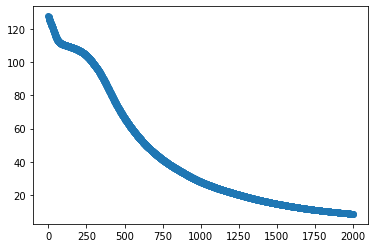

<Figure size 432x288 with 0 Axes>

In [87]:
images, labels = read_spiral_from_file()
W_learned1, b_learned1, omega_learned1, my_learned1, z1, J_list1 = trening(images, labels, h = 0.1, n = 2000, AdamOrPlain = 'adam')
success1 = success(z1,labels*1)

plotJ(J_list1)

In [ ]:
Y_k1 = forward_function(images, W_learned1, b_learned1, h)
#plot_progression(np.array(Y_k1), labels*1)
#plot_separation(findZvalue, Y_k1[-1], omega_learned1, my_learned1, labels*1, 2000)
plot_model(forward_function, Y_k1[0], W_learned1, b_learned1, 0.1, labels*1, 100)
print(success1)
#writeParams(W_learned1, b_learned1, omega_learned1, my_learned1, filename = 'spiral_adam_2000_it_0.1')

In [ ]:
#den gamle koden
def trening1(n=1000, tau=0.01, h = 0.1):
    features, labels = read_spiral_from_file()
    W_k, b_k, omega, my = getRandomParam(2, K)

    c_vec = labels * 1
    Y_k = [features]

    # m = makeMandV(K, d)
    # v = makeMandV(K, d)

    mW = np.zeros_like(W_k)
    mb = np.zeros_like(b_k)
    mOmega = np.zeros_like(omega)
    mMy = np.zeros_like(my)

    vW = np.zeros_like(W_k)
    vb = np.zeros_like(b_k)
    vOmega = np.zeros_like(omega)
    vMy = np.zeros_like(my)
    J_list = []

    for i in range(n):
        Y_k = [features]
        for i in range(W_k.shape[0]):
            Y_next = findNextYMat(Y_k[-1], W_k[i], b_k[i], h)
            Y_k.append(Y_next)

        z_vec = findZvalue(Y_k[-1], omega, my)

        # Nå inneholder Y_k ALLE k, dvs at Y_end er med i Y_k, og må derfor skilles ut før Y_k settes inn i
        # Gradientfunksjonen

        J_diff_W, J_diff_b, J_diff_omega, J_diff_my = findGradJ(z_vec, W_k, Y_k[:-1], Y_k[-1], omega, c_vec, my, b_k, h, K)
        # W_k, b_k, omega, my = U_jPlussEn(W_k,b_k,omega,my,tau,J_diff_W,J_diff_b,J_diff_omega,J_diff_my)
        
        mW, vW, JW = adam2(mW, vW, J_diff_W, i + 1)
        mb, vb, Jb = adam2(mb, vb, J_diff_b, i + 1)
        mOmega, vOmega, JOmega = adam2(mOmega, vOmega, J_diff_omega, i + 1)
        mMy, vMy, JMy = adam2(mMy, vMy, J_diff_my, i + 1)

        W_k -= JW
        b_k -= Jb
        omega -= JOmega
        my -= JMy
        J_list.append(J(findZvalue(Y_k[-1], omega, my), c_vec))

    return (W_k, b_k, omega, my, features, labels, J_list)



def MNIST(n, tau = 0.01, h = 0.05, K = 10):
    start = timeit.default_timer()
    W_k, b_k, omega, my = getRandomParam(28 * 28, 10)
    # Vi får svært store verdier, så normerer alle startmatrisene litt
    W_k = np.dot(W_k, 1 / (28 ** 2))
    omega = np.dot(omega, 1 / (28 ** 2))

    mW = np.zeros_like(W_k)
    mb = np.zeros_like(b_k)
    mOmega = np.zeros_like(omega)
    mMy = np.zeros_like(my)

    vW = np.zeros_like(W_k)
    vb = np.zeros_like(b_k)
    vOmega = np.zeros_like(omega)
    vMy = np.zeros_like(my)
    J_list = []
    for i in range(n):
        chunk_start = random.randint(0, images.shape[1] - 500)
        Y_k = [images[:, chunk_start:chunk_start + 500]]
        for i in range(W_k.shape[0]):
            Y_next = findNextYMat(Y_k[-1], W_k[i], b_k[i])
            Y_k.append(Y_next)
        print("Ferdig med matrisene")
        z_vec = findZvalue(Y_k[-1], omega, my)
        J_diff_W, J_diff_b, J_diff_omega, J_diff_my = findGradJ(z_vec, W_k, Y_k[:-1], Y_k[-1], omega,
                                                                C_vec[chunk_start:chunk_start + 500], my, b_k, h, K)
        # W_k, b_k, omega, my = U_jPlussEn(W_k,b_k,omega,my,tau,J_diff_W,J_diff_b,J_diff_omega,J_diff_my)

        mW, vW, JW = adam2(mW, vW, J_diff_W, i + 1)
        mb, vb, Jb = adam2(mb, vb, J_diff_b, i + 1)
        mOmega, vOmega, JOmega = adam2(mOmega, vOmega, J_diff_omega, i + 1)
        mMy, vMy, JMy = adam2(mMy, vMy, J_diff_my, i + 1)

        W_k -= JW
        b_k -= Jb
        omega -= JOmega
        my -= JMy
        J_list.append(J(findZvalue(Y_k[-1], omega, my), C_vec[chunk_start:chunk_start + 500]))
    print(timeit.default_timer() - start)
    return (W_k, b_k, omega, my, J_list)


W_k_mnist, b_k_mnist, omega_mnist, my_mnist, J_list_mnist = MNIST(10)
Y_k_mnist = [images]
J_list_layer = [J(findZvalue(Y_k_mnist[-1], omega_mnist, my_mnist), C_vec)]
for i in range(W_k_mnist.shape[0]):
    Y_next = findNextYMat(Y_k_mnist[-1], W_k_mnist[i], b_k_mnist[i])
    Y_k_mnist.append(Y_next)
    J_list_layer.append(J(findZvalue(Y_k_mnist[-1], omega_mnist, my_mnist), C_vec))
Y_k_mnist = np.array(Y_k_mnist)
# print(J_list_layer)
print(J_list_mnist)

In [ ]:

#Her har vi funnet endelige matriser, vektorer og verdier vi ønsker å bruke 
#på spiralen til slutt
W_k_learned, b_k_learned, omega_learned, my_learned, features_1, labels_1, J_list1= trening1()
Y_k_final = [features_1]
J_list1_per_layer = [J(findZvalue(Y_k_final[-1], omega_learned, my_learned), labels_1 * 1)]
for i in range(W_k_learned.shape[0]):
    Y_next = findNextYMat(Y_k_final[-1], W_k_learned[i], b_k_learned[i])
    Y_k_final.append(Y_next)
    #J_list1_per_layer.append(J(findZvalue(Y_k_final[-1], omega_learned, my_learned), labels_1 * 1))
#Har nå funnet alle Y også.
Y_k_final = np.array(Y_k_final)


#Definerer andre testsett:
features_2, labels_2 = read_spiral_from_file('spiral_text_file2.txt')
Y_k_final2 = [features_2]
#J_list2_per_layer = [J(findZvalue(Y_k_final2[-1], omega_learned, my_learned), labels_2 * 1)]
for i in range(W_k_learned.shape[0]):
    Y_next2 = findNextYMat(Y_k_final2[-1], W_k_learned[i], b_k_learned[i])
    Y_k_final2.append(Y_next2)
    #J_list2_per_layer.append(J(findZvalue(Y_k_final2[-1], omega_learned, my_learned), labels_2 * 1))
Y_k_final2 = np.array(Y_k_final2)


Nedenfor er funksjonene brukt i $trening$. $getRandomParam$ lager tilfeldige startverdier for vekter, bias, $\omega$ og $\mu$. Startverdiene er tatt fra den standarde normalfordelingen.

In [81]:
def getRandomParam(d=2, K=20):
    w_k=np.random.randn(K,d,d)
    b_k=np.random.randn(K,d)
    omega = np.random.randn(d)
    my = np.random.rand(1)
    return w_k,b_k,omega, my

In [82]:
def sigma(x):
    return(np.tanh(x))

def sigma_diff(x):
    return(1-np.tanh(x)**2)

def eta(x):
    x[x > 350] = 300
    return(np.exp(x)/(np.exp(x)+1))
    #return 1/2*(1+np.tanh(x/2))

def eta_diff(x):
    x[x > 350] = 300
    return np.exp(x)/(np.exp(x) + 1)**2
    #return 1/4*(1-np.tanh(x/2)**2)
        
#Hjelpefunskjon for å regne ut vektorproduktet V_1@V_2^T
def makeMatrixFromVec(a, b):
    return_matrix = np.zeros((len(a), len(b)))
    for i in range(len(b)):
        return_matrix[:, i] = b[i]*a
    return(return_matrix)
    
def findNextYVec(Y_k, W_k, b_k, h):
    vec_for_sigma = np.dot(W_k, Y_k) + b_k
    sigma_vec = sigma(vec_for_sigma)
    return(Y_k+h*sigma_vec)

def findNextYMat(Y_k_mat, W_k, b_k, h):
    numberOfColumns = Y_k_mat.shape[1]
    nextYMat = np.zeros((Y_k_mat.shape[0], numberOfColumns))
    for column in range(numberOfColumns):
        Y_k = Y_k_mat[:, column]
        nextYMat[:, column] = findNextYVec(Y_k, W_k, b_k, h)
    return(np.array(nextYMat))

def findZvalue(Y_k_mat, w_vec, my):
    vec_for_eta = np.dot(w_vec, Y_k_mat) + my
    return(eta(vec_for_eta))

def findGradJ(Z_vec, W_K, Y_K, Y_end, w_vec, c_vec, my, b_K, h, K):
    #Regner ut et produkt som går igjen for å spare noen utregninger
    prod_to_re_use = eta_diff(np.dot(w_vec, Y_end)+my) 
    J_diff_my = np.dot(prod_to_re_use, Z_vec-c_vec)
    #dJ/dw  = Y_K * [(Z-c)had*eta_diff(Y_K^T*w + my*1Vec]
    #had* er hadamard-produktet, som bare er å gange sammen alle elementene for seg, 1Vec er en vektor fylt med enere
    diff_my_vec_for_product = np.multiply(Z_vec - c_vec, prod_to_re_use)
    J_diff_w = np.dot(Y_end, diff_my_vec_for_product)
    #Definerer P_K = dJ/dY_K
    #dJ/dY_K = w_vec * [(Z_vec - c_vec)had*eta_diff(Y_K^T * w_vec + my*Vec1)]^T
    #Rekursivt:
    #P_k-1: P_k + h*W_k-1^T*[sigma_diff(W_k-1*Y_k-1 + b_k-1)had*P_k)
    P_K = makeMatrixFromVec(w_vec, np.multiply(Z_vec - c_vec, prod_to_re_use))
    #Ønsker nå å samle opp for alle de deriverte k < K:
    P_k_liste = [P_K]
    #Ønsker å lage b_k som en matrise, b_k har samme dimensjon som en kolonne av WdotY, men den må være like lang
    for i in range(K-1, -1, -1):
        #Starter å indeksere fra toppen, fordi W_k og Y_k inneholder k < K
        WdotY = np.dot(W_K[i], Y_K[i])
        b_i_mat = np.array([np.array([b_K[i][j] for e in range(WdotY.shape[1])]) for j in range(WdotY.shape[0])])
        matrix_for_sigma_diff =  WdotY + b_i_mat
        matrix_for_product = np.multiply(sigma_diff(matrix_for_sigma_diff), P_k_liste[0])
        P_i = P_k_liste[0] + h * np.dot(np.transpose(W_K[i]), matrix_for_product)
        P_k_liste.insert(0, P_i)
    J_diff_W_matrix = []
    #dJ/dW_k = h*[P_k+1 *had sigma_diff(W_k*Y_k + b_k)]*Y_k^T
    J_diff_b_vec = []
    #dJ/db_k = h*[P_k+1 *had sigma_diff(W_k*Y_k + b_k)]*
    for j in range(K):
        W_jY_j = np.dot(W_K[j], Y_K[j])
        b_j_mat = np.array([np.array([b_K[j][c] for e in range(W_jY_j.shape[1])]) for c in range(W_jY_j.shape[0])])
        one_vector = np.full((W_jY_j.shape[1]), 1)
        J_diff_W_matrix.append(h*np.dot(P_k_liste[j+1]*sigma_diff(W_jY_j + b_j_mat), np.transpose(Y_K[j])))
        J_diff_b_vec.append(h*np.dot(P_k_liste[j+1]*eta_diff(W_jY_j + b_j_mat), one_vector))
    return(J_diff_W_matrix, J_diff_b_vec, J_diff_w, J_diff_my)

In [83]:
def J(Z,c):
    return 0.5*np.linalg.norm(Z-c)**2

Funksjonene $newU$ og $adam$ optimerer parameterne henholdsvis for første og andre testproblem. $newU$ bruker "plain vanilla gradient descent", mens $adam$ bruker Adam-metoden for å oppdatere parameterne. 

In [84]:
def newU(W_k,b_vec,w,my,tau,J_diff_W_matrix, J_diff_b_vec, J_diff_w, J_diff_my):
    W_k = W_k - np.multiply(J_diff_W_matrix,tau)
    b_vec = b_vec - np.multiply(J_diff_b_vec, tau)
    w = w - tau*J_diff_w
    my = my -tau*J_diff_my
    return W_k, b_vec,w,my

In [85]:
def adam2(m,v,g,j):
    beta1 = 0.9
    beta2 = 0.999
    alpha = 0.01
    epsilon = 1.0E-8

    m = np.multiply(beta1,m) + np.multiply((1-beta1),g)
    v = np.multiply(beta2,v) + np.multiply((1-beta2),np.multiply(g,g))
    m_hat = np.multiply(m,1/(1-beta1**j))
    v_hat = np.multiply(v,1/(1-beta2**j))
    
    J = np.multiply(alpha,np.multiply(m_hat,1/((np.sqrt(v_hat)+epsilon))))
    
    return m,v,J

def getStartMandV(w,b,o,m):
    mW = np.zeros_like(w)
    mb = np.zeros_like(b)
    mOmega = np.zeros_like(o)
    mMy = np.zeros_like(m)

    return mW,mb,mOmega,mMy

In [86]:
def forward_function(Y_0, W_k, b_k, h):
    Y_k = [Y_0]
    for i in range(W_k.shape[0]):
        Y_next = findNextYMat(Y_k[-1], W_k[i], b_k[i], h)
        Y_k.append(Y_next)
    return(Y_k)

#Forward tar inn Y_0, og lager Y_k helt til K ved hjelp av de fire parameterne. Må ta inn de learned parameterne. 
#Forward function skal bruke parameterne som allerede er oppdaterte og lagret i minnet, men den skal bruke de på nye
#datapunkter Y_0, og gå gjennom alle k helt til Y_K.

#Last funtion tar inn den siste Y_K, og returnere Z for denne matrisen. 
    
def last_function(Y_K_final, omega, my): #Tar inn Y_K, det siste laget. Altså Y_K final. Første paramter er grid
    Z=findZvalue(Y_K_final, omega, my)
    return Z  

In [99]:

def plot_progression(Y, C):
    '''
    This function should make K+1 plots showing how, as the network progresses through its layers,
    the datapoints are drawn apart in such a way that they can be separated by a straight line.
    
    Y: A K+1-by-I-by-2 matrix of the values for each data point in the training set in each layer.
    C: An I-by-1 matrix of the labels corresponding to the datra points in Y.
    '''
    for k in range(Y.shape[0]):
        show_dots(Y[k,:,:],C.flatten())
        plt.show()


def plot_model(forward_function, Ys, W_k, b_k, h, C, n):
    '''
    Make a map that shows what part of the 2d plane is classified as belonging to which spiral arm.
    Also plot the training data in Ys, C.
    
    forward_function: A function that takes one argument, an S-by-2 matrix of S datapoints, and
        returns a vector of S classification values.
        
        Hint: This function will use the weights you have found, so you might want it to be a method on a
        class called something like Network or Model.
    Ys: An I-by-2 matrix. Corresponding to Y[0,:,:]
    C: An I-by-1 matrix of the labels corresponding to the datra points in Ys.
    n: Number of test-points in each direction. This controls the resolution of the plot.
    '''
    grid, coordinates = get_discretization(Ys, n)

    Z = forward_function(grid, W_k, b_k, h)
    l = np.linspace(0,1,8)
    l = np.array([shading(x) for x in l])

    plot_contours(*coordinates, Z, l, Ys, C.flatten())


def plot_separation(last_function, Ys, omega, my, C, n):
    '''
    Show how the training data is represented in the last layer. Also maps the rest of the possible points in the plane.
    
    last_function: A function that takes one argument, and S-by-2 matrix of S intermediate states in
        the network, and retruns a vector of S classification values.
        It should multiply by w, add μ and evaluate 𝜂.
        
        Hint: This function will use the weights you have found, so you might want it to be a method on a
        class called something like Network or Model.
    Ys:An I-by-2 matrix. Corresponding to Y[-1,:,:].
    C: An I-by-1 matrix of the labels corresponding to the datra points in Ys.
    n: Number of test-points in each direction. This controls the resolution of the plot.
    '''
    grid, coordinates = get_discretization(Ys, n)

    Z = last_function(grid, omega, my)
    l = np.linspace(0,1,500)

    plot_contours(*coordinates, Z, l, Ys, C.flatten())


######## Internals


def show_dots(positions, labels):
    '''Visualize the output of get_data_spiral_2d'''
    plt.scatter(x=positions[0,:], y=positions[1,:], s=1, c=labels, cmap='bwr')
    plt.axis([-1.2, 1.2, -1.2, 1.2])
    plt.axis('square')


def plot_contours(box, xcoordinates, ycoordinates, Z, l, Ys, C1):
    n = xcoordinates.size
    plt.contourf(xcoordinates, ycoordinates, Z.reshape((n,n)), cmap='seismic', levels=l)
    plt.contour(xcoordinates, ycoordinates, Z.reshape((n,n)), levels=1, colors='k')
    plt.scatter(x=Ys[0,:], y=Ys[1,:], s=1, c=C1, cmap='bwr')
    plt.axis(box)
    plt.axis('equal')
    plt.show()


def get_discretization(Ys, n):
    xmin, xmax, ymin, ymax = get_box(Ys)
    xcoordinates = np.linspace(xmin, xmax, n)
    ycoordinates = np.linspace(ymin, ymax, n)
    grid = get_grid(xcoordinates, ycoordinates)
    coordinates = ([xmin, xmax, ymin, ymax], xcoordinates, ycoordinates)
    return grid, coordinates


def get_box(Ys):
    xmin = min(Ys[0,:])
    xmax = max(Ys[0,:])
    xdelta = xmax-xmin
    xmin -= 0.2*xdelta
    xmax += 0.2*xdelta
    ymin = min(Ys[1,:])
    ymax = max(Ys[1,:])
    ydelta = ymax-ymin
    ymin -= 0.2*ydelta
    ymax += 0.2*ydelta
    return xmin, xmax, ymin, ymax

    
def get_grid(xcoordinates, ycoordinates):
    xv, yv = np.meshgrid(xcoordinates, ycoordinates)
    xs = xv.reshape(-1)
    ys= yv.reshape(-1)
    grid = np.stack([xs,ys])
    return grid


def shading(x):
    return shading1(shading2(x))


def shading1(x):
    if x == 0.0:
        return 0.0
    return 0.5 * np.tanh(np.tan(x * np.pi + np.pi / 2.0)) + 0.5


def shading2(x):
    if x < 0.5:
        return 0.5 - np.sqrt(0.25 - x**2)
    else:
        return 0.5 + np.sqrt(0.25 -(x-1.0)**2)


# 3. Første testproblem: Punkter i planet

In [ ]:
def success(z, int_labels):
    #asanyarray tillater oss å sette typen til alle elementer i arrayen. Vi vil ha heltall.
    z = np.asanyarray(np.around(z, 0), dtype = int)
    sum = 0
    for i in range(len(z)):
        if z[i] == int_labels[i]:
            sum += 1
    return(sum/len(z))

In [ ]:
def plotJ(J_liste):
    x_akse = np.arange(len(J_liste))
    plt.scatter(x_akse, J_liste)
    plt.figure(10)
    plt.show()

In [ ]:
#C_1 = labels_1 * 1
#C_2 = labels_2 * 1



#plot_progression(Y_k_final, C_1)
#plot_progression(Y_k_final2, C_2)



#plotJ(J_list1)
#plotJ(J_list_layer)
#plotJ(J_list_mnist)

# 4. Andre testproblem: Siffergjenkjenning

In [ ]:
#Z_vec2 = findZvalue(Y_k_final2[-1], omega_learned, my_learned)
#Z_vec1 = findZvalue(Y_k_final[-1], omega_learned, my_learned)
Z_vec_mnist = findZvalue(Y_k_mnist[-1], omega_mnist, my_mnist)

#print(success(Z_vec2, C_2))
#print(success(Z_vec1, C_1))
print(success(Z_vec_mnist, C_vec))

#Lager meg en test:
W_k_test, b_k_test, omega_test, my_test = getRandomParam(28*28, 10)
#Vi får svært store verdier, så normerer alle startmatrisene litt
W_k_test = np.dot(W_k_test, 1/(28**2))
omega_test = np.dot(omega_test, 1/(28**2))
Y_k_test = [images]
for i in range(W_k_test.shape[0]):
    Y_next = findNextYMat(Y_k_mnist[-1], W_k_test[i], b_k_test[i])
    Y_k_test.append(Y_next)
Y_k_test = np.array(Y_k_test)
Z_vec_test = findZvalue(Y_k_test[-1], omega_test, my_test)
success(Z_vec_test, C_vec)

In [ ]:
def write_spiral_to_file(filename = 'spiral_text_file.txt', n = 200):
    features, labels = get_data_spiral_2d(n)
    try:
        file = open(filename, 'x')
    except FileExistsError:
        file = open(filename, 'w')
    features_0 = ''
    features_1 = ''
    labels_str = ''
    #Itererer gjennom nesten hele datasettet, fordi siste element skal håndteres litt annerledes
    for n in range(len(features[0]) - 1):
        features_0 += str(features[0][n]) + ', '
        features_1 += str(features[1][n]) + ', '
        labels_str += str(labels[n][0]) + ', '
    features_0 += str(features[0][len(features[0]) - 1]) + '\n'
    features_1 += str(features[1][len(features[0]) - 1]) + '\n'
    labels_str += str(labels[len(features[0]) - 1][0]) + '\n'
    file.write(features_0)
    file.write(features_1)
    file.write(labels_str)
    file.close()
    
def read_spiral_from_file(filename = 'spiral_text_file.txt'):
    #Denne funksjonen leser en fil som er lagret på formatet fra write_spiral_to_file
    file = open(filename, 'r')
    #Vet at filen lagres med tre linjer
    features_0 = file.readline()
    features_0.strip()
    features_list_0 = features_0.split(', ')
    features_1 = file.readline()
    features_1.strip()
    features_list_1 = features_1.split(', ')
    labels_str = file.readline()
    labels_list = labels_str.split(', ')
    for i in range(len(labels_list)):
        features_list_0[i] = float(features_list_0[i])
        features_list_1[i] = float(features_list_1[i])
        if labels_list[i] == 'True':
            labels_list[i] = True
        else:
            labels_list[i] = False
    return(np.array([features_list_0, features_list_1]), np.array(labels_list))

#write_spiral_to_file('spiral_text_file.txt', n = 1000)
#write_spiral_to_file('spiral_text_file2.txt', n = 1000)
#features, labels = read_spiral_from_file()
#print(features, labels)

In [90]:
def writeParams(W_k, b_k, omega, my, filename = 'trainingParams.txt'):
    try:
        file = open(filename, 'x')
    except FileExistsError:
        file = open(filename, 'w')

    Wk_str = ""
    for W in W_k:
        for w in W:
            for i in w:
                Wk_str += str(i) + ','
    Wk_str += '\n'

    bk_str = ""
    for B in b_k:
        for b in B:
            bk_str += str(b) + ','
    bk_str += '\n'

    omega_str = ""
    for o in omega:
        omega_str += str(o) + ','
    omega_str += '\n'

    my_str = str(my[0]) + '\n'

    file.write(Wk_str+bk_str+omega_str+my_str)
    file.close()

def readParams(K=20,d=2, filename = 'trainingParams.txt'):
    try:
        file = open(filename, 'r')
    except FileExistsError:
        print("Kunne ikke finne",filename)

    w_k = np.zeros((K, d, d))
    b_k = np.zeros((K, d))
    omega = np.zeros(d)
    my = np.zeros(1)

    W = file.readline().split(',')
    B = file.readline().split(',')
    O = file.readline().split(',')
    M = file.readline()

    file.close()

    for k in range(K):
        for w in range(d):
            for i in range(d):
                w_k[k][w][i]= float(W[0])
                W.pop(0)

    for k in range(K):
        for i in range(d):
            b_k[k][i]=float(B[0])
            B.pop(0)


    for i in range(d):
        omega[i] = float(O[i])

    my[0] = float(M)

    return w_k,b_k,omega,my
